In [36]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
# !ls /home/aistudio/data

In [37]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
# !ls /home/aistudio/work

In [38]:
# !pip install tushare
# !pip install lightgbm # -t /home/aistudio/external-libraries 
# !pip install mpl_finance

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 215kB 20.7MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import os
import tqdm

In [3]:
path = 'stock/OldData/002242.SZ_NormalData.csv'
df = pd.read_csv(path)

In [4]:

base_path = 'stock/features'
stock_info_copy = pd.read_csv(os.path.join(base_path, 'stock_info.csv'))
stock_info = pd.read_csv(os.path.join(base_path, 'feature0.csv'))
stock_info.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)
# stock_info.drop_duplicates(inplace=True)

In [5]:

# 添加涨跌停信息
limit_info = pd.read_csv(os.path.join(base_path, 'limit.csv'))
limit_info['U-D'] = limit_info['U'] - limit_info['D']
limit_info.drop(['U', 'D'], axis=1, inplace=True)
limit_info = limit_info.rename(columns={'date':'trade_date'})
stock_info = stock_info.merge(limit_info, on='trade_date', how='left')
del limit_info

In [6]:

feature_col = ['month', 'weekday', 'vol', 'open_transform', 'high_transform',
       'low_transform', 'close_transform',
       'amount_index_000001_shift_1', 'amount_index_000001_shift_3', 
       'amount_index_000001_shift_5', 'close_index_000001_shift_1',
       'close_index_000001_shift_3','close_index_000001_shift_5',
       'amount_shift_1', 'amount_shift_3', 'amount_shift_5', 'close_shift_1', 'close_shift_3',
        'close_shift_5', 'turnover_rate', 'U-D']

# 标签读取

In [7]:
label_path = os.path.join('stock','label', 'label.csv')
label = pd.read_csv(label_path)
label = label[['ts_date_id', 'label_final', 'open', 'high', 'low', 'close', 'ma5', 'ma13', 'ma21', 'name']]

In [8]:
# stock_info.drop(['open', 'trade_date', 'ts_code'], axis=1, inplace=True)
label['ts_date_id'] = label['ts_date_id'] - 1
stock_info = stock_info.merge(label, on='ts_date_id', how='left')

In [9]:
stock_info.dropna(inplace=True)
stock_info = stock_info.reset_index(drop=True)
print(len(stock_info))

2475341


# 模型训练

In [12]:

len(feature_col)

21

In [13]:
trn_col = feature_col
# trn_col.remove('month')
# 'high', 'low', 'close', 'pre_close',
# trn_col = list(set(trn_col))
label = 'label_final'
# trn_date_min = 20170103
# trn_date_max = 20190416
# val_date_min = 20190417
# val_date_max = 20190429
# test_date_min = 20190417
# test_date_max = 20191218

trn_date_min = 20160103
trn_date_max = 20190831
val_date_min = 20190101
val_date_max = 20190419
test_date_min = 20190901
test_date_max = 20200301

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max) & (stock_info['high']!=stock_info['close'])
val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col]
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col]
val_label = stock_info[val_data_idx][label].values 

test = stock_info[test_data_idx][trn_col]
test_label = stock_info[test_data_idx][label].values

print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('number of features:%d' % len(trn_col))
print(feature_col)

rate of 0: 0.7762, rate of 1: 0.2238
trn data:2011124, val data:201234, test data:334367
number of features:21
['month', 'weekday', 'vol', 'open_transform', 'high_transform', 'low_transform', 'close_transform', 'amount_index_000001_shift_1', 'amount_index_000001_shift_3', 'amount_index_000001_shift_5', 'close_index_000001_shift_1', 'close_index_000001_shift_3', 'close_index_000001_shift_5', 'amount_shift_1', 'amount_shift_3', 'amount_shift_5', 'close_shift_1', 'close_shift_3', 'close_shift_5', 'turnover_rate', 'U-D']


In [14]:
# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics
param = {'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective': 'binary',
         'learning_rate': 0.06,
         "boosting": "gbdt",
#          "bagging_freq": 1,
#          "bagging_seed": 11,
        #  'objective':'multiclass',
         "metric": 'None',
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round = 666
# clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100,
#                 early_stopping_rounds=300, feval=win_score_eval)
clf = lgb.train(param, trn_data, num_round)
# oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

In [15]:
# 模型保存
import pickle
save_path = 'model.pickle'
with open(save_path, 'wb') as f:
    pickle.dump(clf, f)

In [16]:
pd.DataFrame({
        'column': trn_col,
        'importance': clf.feature_importance(),
    }).sort_values(by='importance', ascending=False)

,column,importance
20,U-D,1598
0,month,1577
10,close_index_000001_shift_1,1541
12,close_index_000001_shift_5,1505
11,close_index_000001_shift_3,1503
8,amount_index_000001_shift_3,1399
7,amount_index_000001_shift_1,1384
9,amount_index_000001_shift_5,1365
19,turnover_rate,1267
16,close_shift_1,794


# 读取指数信息

In [17]:
# #############
# 读取指数信息
# ############
base_path = 'stock'
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

tmp_list = list(index_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))
index_df['trade_date_id'] = index_df['trade_date'].map(date_map)

index_df['rate1'] = (index_df['open'] - index_df['pre_close']) / index_df['pre_close']
index_df['rate2'] = (index_df['close'] - index_df['pre_close']) / index_df['pre_close']

# 指数清仓指标
index_df['sell_flag'] = 0

# 收盘大跌1.5个点，sell flag=2
idx = index_df['rate2'] <= -0.015
index_df.loc[idx, 'sell_flag'] = 2

# 开盘大跌两个点，sell flag=1

idx = index_df['rate1'] <= -0.02
index_df.loc[idx, 'sell_flag'] = 1

index_df = index_df.sort_values('trade_date', ascending=True).reset_index(drop=True)

# 回测

In [18]:
test_lgb

array([0.18886596, 0.10227889, 0.117513  , ..., 0.10702118, 0.65277511,
       0.33141791])

In [19]:
stock_info.columns

Index(['month', 'weekday', 'vol', 'open_transform', 'high_transform',
       'low_transform', 'high_transform.1', 'close_transform',
       'amount_index_000001_shift_1', 'amount_index_000001_shift_2',
       'amount_index_000001_shift_3', 'amount_index_000001_shift_4',
       'amount_index_000001_shift_5', 'close_index_000001_shift_1',
       'close_index_000001_shift_2', 'close_index_000001_shift_3',
       'close_index_000001_shift_4', 'close_index_000001_shift_5',
       'amount_shift_1', 'amount_shift_2', 'amount_shift_3', 'amount_shift_4',
       'amount_shift_5', 'close_shift_1', 'close_shift_2', 'close_shift_3',
       'close_shift_4', 'close_shift_5', 'turnover_rate', 'trade_date',
       'ts_code', 'ts_date_id', 'U_max_5', 'D_max_5', 'U_mean_5', 'D_mean_5',
       'Umean-Dmeam5', 'U_max_10', 'D_max_10', 'U_mean_10', 'D_mean_10',
       'Umean-Dmeam10', 'U_max_13', 'D_max_13', 'U_mean_13', 'D_mean_13',
       'Umean-Dmeam13', 'U_max_21', 'D_max_21', 'U_mean_21', 'D_mean_21',
 

In [ ]:
thresh_hold = 0.5
oof_test_final = test_lgb >= thresh_hold

print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('accuracy1:%.3f'% (tp/(pp)))


In [21]:
oof_test_final

array([False, False, False, ..., False,  True, False])

In [22]:

# test_postive_idx = np.argwhere(oof_test_final != 0).reshape(-1)
test_postive_idx = np.argwhere(oof_test_final == True).reshape(-1)
# test_postive_idx = list(range(len(oof_test_final)))
test_all_idx = np.argwhere(np.array(test_data_idx)).reshape(-1)
stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
stock_info['trade_date_id'] = stock_info['trade_date_id'] + 1 # 向下移动一天

In [23]:

# 查看选了哪些股票

tmp_col = ['ts_code', 'trade_date', 'trade_date_id', 'open', 'high', 'low', 'close', 
           'ma5', 'ma13', 'ma21', 'label_final', 'name']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
tmp_df['label_prob'] = test_lgb[test_postive_idx]
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)

In [28]:
buy_df['buy_flag'] = 1
stock_info_copy['sell_flag'] = 0

In [29]:
print(len(buy_df), sum(buy_df['label_final']))
print(len(buy_df), sum(buy_df['label_final']==1))

43056 20331.0
43056 20331


In [30]:

tmp_idx = (index_df['trade_date'] == test_date_min+1)
close1 = index_df[tmp_idx]['close'].values[0]
test_date_max = 20200228
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [31]:

tmp_idx = (stock_info_copy['trade_date'] >= test_date_min) & (stock_info_copy['trade_date'] <= test_date_max)
tmp_df = stock_info_copy[tmp_idx].reset_index(drop=True)

In [32]:

from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init, max_hold_period=20, stop_loss_rate=-0.07, stop_profit_rate=0.12)
account.BackTest(buy_df, tmp_df, index_df, buy_price='open')

20190923  买入 德宏股份 (603701.SH) 1500股，股价：13.25,花费：19875.0,手续费：5.96，剩余现金：80119.04
20190923  买入 深大通 (000038.SZ) 1400股，股价：13.58,花费：19012.0,手续费：5.7，剩余现金：61101.33
20190923  买入 恒铭达 (002947.SZ) 300股，股价：61.27,花费：18381.0,手续费：5.51，剩余现金：42714.82
20190923  买入 易尚展示 (002751.SZ) 600股，股价：30.4,花费：18240.0,手续费：5.47，剩余现金：24469.35
20190923  买入 海星股份 (603115.SH) 700股，股价：27.6,花费：19320.0,手续费：5.8，剩余现金：5143.55
20190923  买入 柯力传感 (603662.SH) 100股，股价：48.76,花费：4876.0,手续费：5，剩余现金：262.55
20190925  止损卖出海星股份 (603115.SH) 700股，股价：25.392,收入：17774.4,手续费：23.11，剩余现金：18013.84，最终亏损：-1574.5
20190925  止损卖出易尚展示 (002751.SZ) 600股，股价：27.967999999999996,收入：16780.8,手续费：21.82，剩余现金：34772.83，最终亏损：-1486.49
20190926  止损卖出柯力传感 (603662.SH) 100股，股价：44.859199999999994,收入：4485.92,手续费：9.49，剩余现金：39249.26，最终亏损：-404.57
20190926  止损卖出恒铭达 (002947.SZ) 300股，股价：56.3684,收入：16910.52,手续费：21.98，剩余现金：56137.8，最终亏损：-1497.98
20190926  止损卖出深大通 (000038.SZ) 1400股，股价：12.493599999999999,收入：17491.04,手续费：22.74，剩余现金：73606.1，最终亏损：-1549.4
20190926  止损卖出德宏股份 (603701.SH) 1500股

In [33]:

tmp_df2 = buy_df[['ts_code', 'trade_date', 'label_prob', 'label_final']]
tmp_df2 = tmp_df2.rename(columns={'trade_date':'buy_date'}) 
tmp_df = account.info
tmp_df['buy_date'] = tmp_df['buy_date'].apply(lambda x: int(x)) 
tmp_df = tmp_df.merge(tmp_df2, on=['ts_code', 'buy_date'], how='left')

In [34]:

account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:-0.0396
上证指数浮动情况:-0.0150
交易胜率:0.3191
最大回撤率:0.1878


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


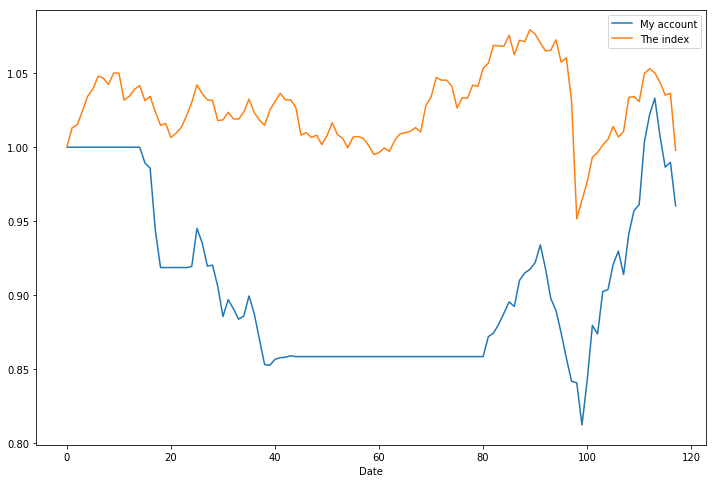

In [35]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min+1]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 